# E09: System with contemporaneous links

In [38]:
import os, sys
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pymp # type: ignore

sys.path.append(os.path.abspath('../utils'))
import surd as surd
import it_tools as it

# Configure matplotlib to use LaTeX for text rendering and set font size
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

## Helper functions

In [39]:
# Function to modify keys based on the condition
def modify_keys(data, var):
    new_data = {}
    for key, value in data.items():
        # Convert the key tuple to a list for easier manipulation
        new_key = list(key)
        # Determine which keys to modify based on i+1
        if var == 1:
            new_key = [5 if x == 4 else 6 if x == 5 else x for x in new_key]
        elif var == 2:
            new_key = [4 if x == 4 else 6 if x == 5 else x for x in new_key]
        elif var == 3:
            new_key = [4 if x == 4 else 5 if x == 5 else x for x in new_key]
        # Convert list back to tuple and store in new dictionary
        new_data[tuple(new_key)] = value
    return new_data

In [40]:
def plot_histograms(X, nbins=100, figsize=None):
    """
    Plots histograms for each variable in the dataset X.
    
    Parameters:
        X (numpy.ndarray): The dataset, where each row represents a variable.
        nbins (int): Number of bins to use in the histograms.
        figsize (tuple): Figure size (width, height) in inches.
    """
    nvars = X.shape[0]  # Number of variables
    if figsize is None:
        figsize = (7, 3 * nvars)  # Default figure size if not provided

    fig, axes = plt.subplots(nvars, 1, figsize=figsize)

    # Ensure 'axes' is iterable even when nvars is 1
    if nvars == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        # Calculate the 1st and 99th percentiles for the current variable
        low, high = np.percentile(X[i, :], 1), np.percentile(X[i, :], 99)

        # Plot histogram on the current axis
        ax.hist(X[i, :], range=(low, high), bins=nbins, edgecolor='black')
        ax.set_title(f'Histogram of variable {i+1}')
        # ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

## System with mediator and contemporaneous effects

In [41]:
def mediator_contemporaneous(N):
    q1, q2, q3 = np.zeros(N), np.zeros(N), np.zeros(N)
    W1, W2, W3 = np.random.normal(0, 1, N), np.random.normal(0, 1, N), np.random.normal(0, 1, N)
    for n in range(1,N-1):
        q2[n+1] = np.cos(q3[n]) + 0.01*W2[n]
        q3[n+1] = 0.5*q3[n] + 0.1*W3[n]
        q1[n+1] = np.sin(q2[n+1]) + 0.001*W1[n]
    return q1, q2, q3

In [42]:
# Specify the directory and file name
directory = '../data'
Nt = 5*10**7              # Number of time steps to perform the integration of the system
formatted_Nt = "{:.0e}".format(Nt).replace("+0", "").replace("+", "")
filename = f'mediator_contemporaneous_Nt_{formatted_Nt}.npy'
filepath = os.path.join(directory, filename)

samples = Nt-10000      # Number of samples to be considered (remove the transients)

# Check if data exists
if not os.path.isfile(filepath):
    # Generate the data
    qs = mediator_contemporaneous(Nt)
    X = np.array([q[-samples:] for q in qs])
    
    # Save the data to a file
    np.save(filepath, X)
else:
    # Load the data from the file
    X = np.load(filepath)
    
nvars = X.shape[0]
nlag = 1
nbins = 25
max_combs = 3

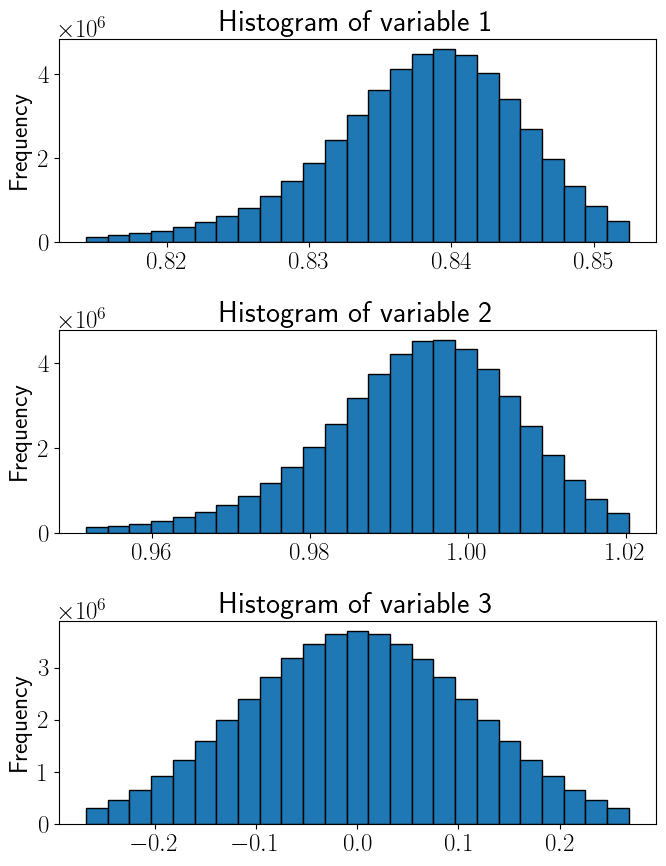

In [43]:
plot_histograms(X, nbins=nbins)

In [44]:
# Initial setup for storing results
Rd_results, Sy_results, MI_results, info_leak_results = \
    pymp.shared.dict({}), pymp.shared.dict({}), pymp.shared.dict({}), pymp.shared.dict({})

with pymp.Parallel(nvars) as par:
    for i in par.range(nvars):
        # Organize data (0 target variable, 1: agent variables)
        Y = X[i, nlag+1:]

        # Create the lagged versions of X and append to the list
        for lag in range(nlag, 0, -1):
            Y = np.vstack([Y, X[:, lag:-nlag + lag - 1]])

        for j in range(nvars):
            if j != i:
                Y = np.vstack([Y, X[j, nlag+1:]])

        # Run SURD
        # ranges = [(np.percentile(Y[i, :], 1), np.percentile(Y[i, :], 99)) for i in range(Y.shape[0])]
        hist, _ = np.histogramdd(Y.T, bins=nbins)
        # Rd, Sy, MI, info_leak = surd.surd(hist)
        Rd, Sy, MI = surd.surd_hd(Y, nbins, max_combs)

        # Calculation of information leak
        hist = it.myhistogram(Y[0,:].T, nbins)
        H  = it.entropy_nvars(hist, (0,) )
        info_leak = 1 - (sum(Rd.values()) + sum(Sy.values())) / H
        
        # Print results
        print(f'SURD CAUSALITY FOR SIGNAL {i+1}')
        surd.nice_print(Rd, Sy, MI, info_leak)  
        Rd_results[i+1], Sy_results[i+1], MI_results[i+1], info_leak_results[i+1] = Rd, Sy, MI, info_leak
        print('\n')

SURD CAUSALITY FOR SIGNAL 2
    Redundant (R):
        (1, 2)      : 0.0000
        (1, 3)      : 0.0000
        (1, 4)      : 0.0000
        (1, 5)      : 0.0000
        (2, 3)      : 0.0000
        (2, 4)      : 0.0000
        (2, 5)      : 0.0000
        (3, 4)      : 0.2048
        (3, 5)      : 0.0000
        (4, 5)      : 0.0000
        (1, 2, 3)   : 0.0000
        (1, 2, 4)   : 0.0000
        (1, 2, 5)   : 0.0000
        (1, 3, 4)   : 0.0000
        (1, 3, 5)   : 0.0000
        (1, 4, 5)   : 0.0000
        (2, 3, 4)   : 0.0000
        (2, 3, 5)   : 0.0000
        (2, 4, 5)   : 0.0000
        (3, 4, 5)   : 0.0050
        (1, 2, 3, 4): 0.0000
        (1, 2, 3, 5): 0.0000
        (1, 2, 4, 5): 0.0000
        (1, 3, 4, 5): 0.0000
        (2, 3, 4, 5): 0.0001
        (1, 2, 3, 4, 5): 0.0071
    Unique (U):
        (1,)        : 0.0000
        (2,)        : 0.0000
        (3,)        : 0.0000
        (4,)        : 0.7741
        (5,)        : 0.0000
    Synergystic (S):
        (1, 2)

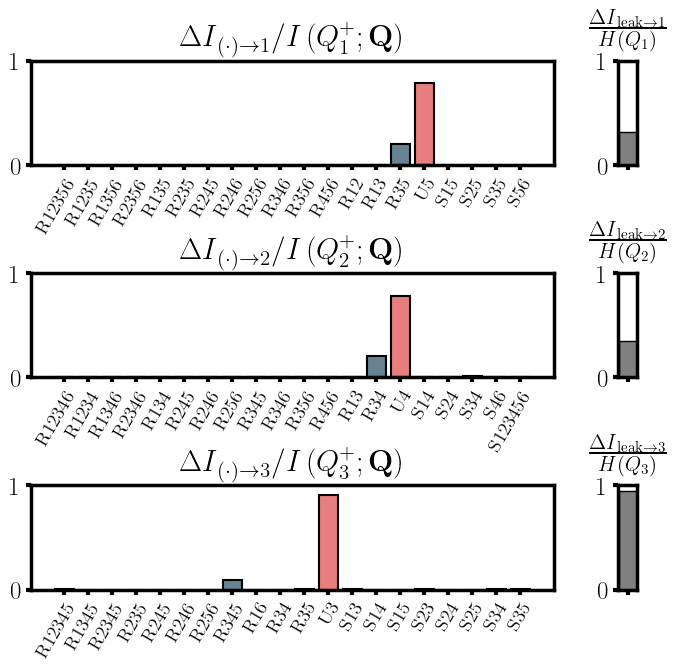

In [45]:
fig, axs = plt.subplots(nvars, 2, figsize=(9, 2.3*nvars), gridspec_kw={'width_ratios': [50, 1]})

for i in range(nvars):
    _ = surd.plot_nlabels(modify_keys(Rd_results[i+1],i+1), modify_keys(Sy_results[i+1],i+1), info_leak_results[i+1], axs[i,:], nvars*nlag+nvars, nlabels=20)
    # Plot formatting
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$', pad=10)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1} \\right)}}$', pad=18)
    axs[i,1].set_yticks([0,1])
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=14, rotation = 60, ha = 'right', rotation_mode='anchor')

    # change all spines
    for axis in ['top','bottom','left','right']:
        axs[i,0].spines[axis].set_linewidth(2.5)
        axs[i,1].spines[axis].set_linewidth(2.5)
    axs[i,0].set_box_aspect(1/5)

plt.tight_layout(w_pad=-7, h_pad=1)

## System with confounder and contemporaneous effects

In [46]:
def confounder_contemporaneous(N):
    q1, q2, q3 = np.zeros(N), np.zeros(N), np.zeros(N)
    W1, W2, W3 = np.random.normal(0, 1, N), np.random.normal(0, 1, N), np.random.normal(0, 1, N)
    for n in range(N-1):
        q3[n+1] = 0.5*q3[n] + 0.1*W3[n]
        q1[n+1] = np.sin(q1[n] + q3[n+1]) + 0.01*W1[n]
        q2[n+1] = np.cos(q2[n] - q3[n+1]) + 0.01*W2[n]
    return q1, q2, q3

In [47]:
# Specify the directory and file name
filename = f'confounder_contemporaneous_Nt_{formatted_Nt}.npy'
filepath = os.path.join(directory, filename)

samples = Nt-10000      # Number of samples to be considered (remove the transients)

# Check if data exists
if not os.path.isfile(filepath):
    # Generate the data
    qs = confounder_contemporaneous(Nt)
    X = np.array([q[-samples:] for q in qs])
    
    # Save the data to a file
    np.save(filepath, X)
else:
    # Load the data from the file
    X = np.load(filepath)
    
nvars = X.shape[0]
nlag = 1
nbins = 25
max_combs = 3

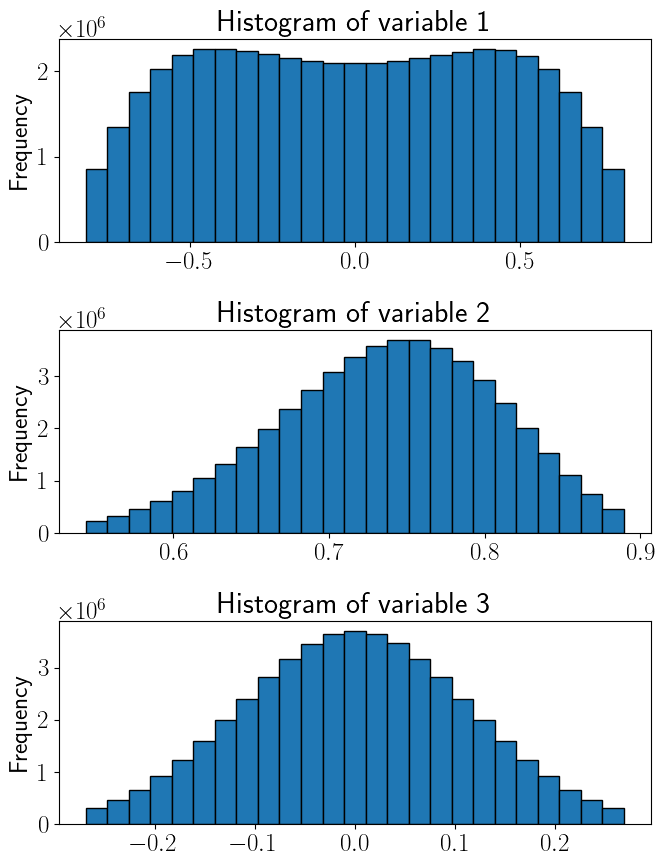

In [48]:
plot_histograms(X, nbins=nbins)

In [49]:
# Initial setup for storing results
Rd_results, Sy_results, MI_results, info_leak_results = \
    pymp.shared.dict({}), pymp.shared.dict({}), pymp.shared.dict({}), pymp.shared.dict({})

with pymp.Parallel(nvars) as par:
    for i in par.range(nvars):
        # Organize data (0 target variable, 1: agent variables)
        Y = X[i, nlag+1:]

        # Create the lagged versions of X and append to the list
        for lag in range(nlag, 0, -1):
            Y = np.vstack([Y, X[:, lag:-nlag + lag - 1]])

        for j in range(nvars):
            if j != i:
                Y = np.vstack([Y, X[j, nlag+1:]])

        # Run SURD
        # ranges = [(np.percentile(Y[i, :], 1), np.percentile(Y[i, :], 99)) for i in range(Y.shape[0])]
        hist, _ = np.histogramdd(Y.T, bins=nbins)
        # Rd, Sy, MI, info_leak = surd.surd(hist)
        Rd, Sy, MI = surd.surd_hd(Y, nbins, max_combs)

        # Calculation of information leak
        hist = it.myhistogram(Y[0,:].T, nbins)
        H  = it.entropy_nvars(hist, (0,) )
        info_leak = 1 - (sum(Rd.values()) + sum(Sy.values())) / H
        
        # Print results
        print(f'SURD CAUSALITY FOR SIGNAL {i+1}')
        surd.nice_print(Rd, Sy, MI, info_leak)  
        Rd_results[i+1], Sy_results[i+1], MI_results[i+1], info_leak_results[i+1] = Rd, Sy, MI, info_leak
        print('\n')

SURD CAUSALITY FOR SIGNAL 3
    Redundant (R):
        (1, 2)      : 0.0000
        (1, 3)      : 0.0000
        (1, 4)      : 0.0000
        (1, 5)      : 0.0000
        (2, 3)      : 0.0000
        (2, 4)      : 0.0000
        (2, 5)      : 0.0000
        (3, 4)      : 0.0000
        (3, 5)      : 0.0016
        (4, 5)      : 0.0092
        (1, 2, 3)   : 0.0000
        (1, 2, 4)   : 0.0000
        (1, 2, 5)   : 0.0000
        (1, 3, 4)   : 0.0000
        (1, 3, 5)   : 0.0000
        (1, 4, 5)   : 0.0000
        (2, 3, 4)   : 0.0000
        (2, 3, 5)   : 0.0000
        (2, 4, 5)   : 0.0000
        (3, 4, 5)   : 0.0387
        (1, 2, 3, 4): 0.0000
        (1, 2, 3, 5): 0.0000
        (1, 2, 4, 5): 0.0000
        (1, 3, 4, 5): 0.0000
        (2, 3, 4, 5): 0.0324
        (1, 2, 3, 4, 5): 0.0205
    Unique (U):
        (1,)        : 0.0000
        (2,)        : 0.0000
        (3,)        : 0.0000
        (4,)        : 0.0000
        (5,)        : 0.1962
    Synergystic (S):
        (1, 2)

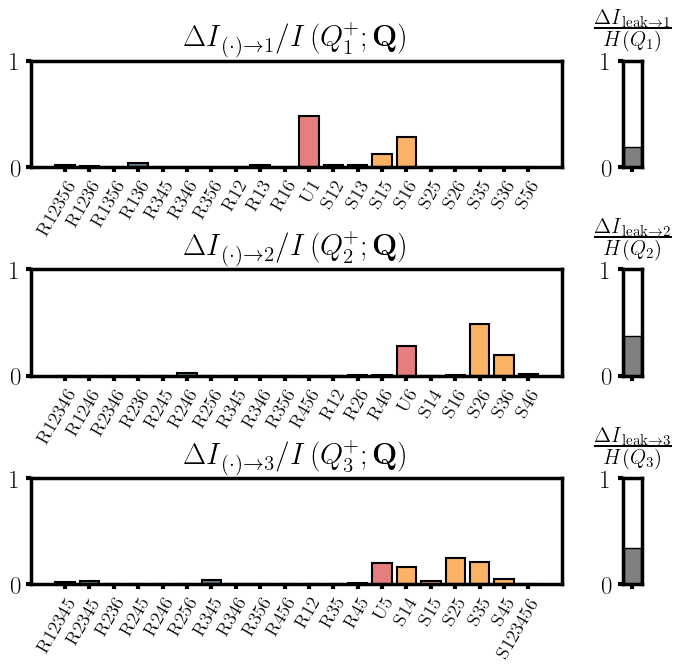

In [50]:
fig, axs = plt.subplots(nvars, 2, figsize=(9, 2.3*nvars), gridspec_kw={'width_ratios': [50, 1]})

for i in range(nvars):
    _ = surd.plot_nlabels(modify_keys(Rd_results[i+1],i+1), modify_keys(Sy_results[i+1],i+1), info_leak_results[i+1], axs[i,:], nvars*nlag+nvars, nlabels=20)
    # Plot formatting
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$', pad=10)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1} \\right)}}$', pad=18)
    axs[i,1].set_yticks([0,1])
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=14, rotation = 60, ha = 'right', rotation_mode='anchor')

    # change all spines
    for axis in ['top','bottom','left','right']:
        axs[i,0].spines[axis].set_linewidth(2.5)
        axs[i,1].spines[axis].set_linewidth(2.5)
    axs[i,0].set_box_aspect(1/5)

plt.tight_layout(w_pad=-7, h_pad=1)

## System with synergistic and contemporaneous effects

In [51]:
def synergistic_contemporaneous(N):
    q1, q2, q3 = np.zeros(N), np.zeros(N), np.zeros(N)
    W1, W2, W3 = np.random.normal(0, 1, N), np.random.normal(0, 1, N), np.random.normal(0, 1, N)
    for n in range(N-1):
        q2[n+1] = 0.5*q2[n] + 0.1*W2[n]
        q3[n+1] = 0.5*q3[n] + 0.1*W3[n]
        q1[n+1] = np.sin(q2[n+1] * q3[n+1]) + 0.001*W1[n]
    return q1, q2, q3

In [52]:
# Specify the directory and file name
filename = f'synergistic_contemporaneous_Nt_{formatted_Nt}.npy'
filepath = os.path.join(directory, filename)

samples = Nt-10000      # Number of samples to be considered (remove the transients)

# Check if data exists
if not os.path.isfile(filepath):
    # Generate the data
    qs = synergistic_contemporaneous(Nt)
    X = np.array([q[-samples:] for q in qs])
    
    # Save the data to a file
    np.save(filepath, X)
else:
    # Load the data from the file
    X = np.load(filepath)
    
nvars = X.shape[0]
nlag = 1
nbins = 25
max_combs = 3

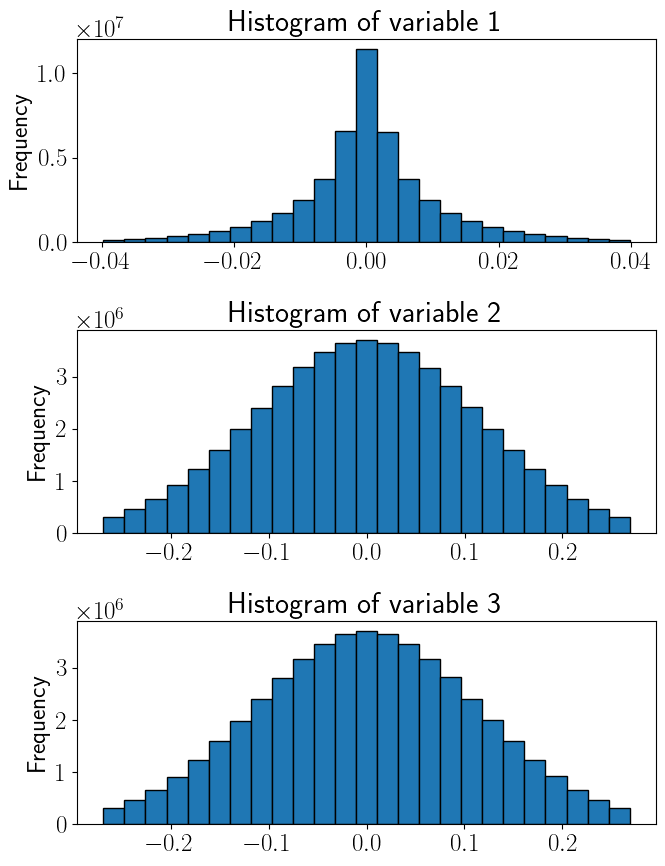

In [53]:
plot_histograms(X, nbins=nbins)

In [54]:
# Initial setup for storing results
Rd_results, Sy_results, MI_results, info_leak_results = \
    pymp.shared.dict({}), pymp.shared.dict({}), pymp.shared.dict({}), pymp.shared.dict({})

with pymp.Parallel(nvars) as par:
    for i in par.range(nvars):
        # Organize data (0 target variable, 1: agent variables)
        Y = X[i, nlag+1:]

        # Create the lagged versions of X and append to the list
        for lag in range(nlag, 0, -1):
            Y = np.vstack([Y, X[:, lag:-nlag + lag - 1]])

        for j in range(nvars):
            if j != i:
                Y = np.vstack([Y, X[j, nlag+1:]])

        # Run SURD
        # ranges = [(np.percentile(Y[i, :], 1), np.percentile(Y[i, :], 99)) for i in range(Y.shape[0])]
        hist, _ = np.histogramdd(Y.T, bins=nbins)
        # Rd, Sy, MI, info_leak = surd.surd(hist)
        Rd, Sy, MI = surd.surd_hd(Y, nbins, max_combs)

        # Calculation of information leak
        hist = it.myhistogram(Y[0,:].T, nbins)
        H  = it.entropy_nvars(hist, (0,) )
        info_leak = 1 - (sum(Rd.values()) + sum(Sy.values())) / H
        
        # Print results
        print(f'SURD CAUSALITY FOR SIGNAL {i+1}')
        surd.nice_print(Rd, Sy, MI, info_leak)  
        Rd_results[i+1], Sy_results[i+1], MI_results[i+1], info_leak_results[i+1] = Rd, Sy, MI, info_leak
        print('\n')

SURD CAUSALITY FOR SIGNAL 1
    Redundant (R):
        (1, 2)      : 0.0000
        (1, 3)      : 0.0000
        (1, 4)      : 0.0000
        (1, 5)      : 0.0000
        (2, 3)      : 0.0000
        (2, 4)      : 0.0000
        (2, 5)      : 0.0000
        (3, 4)      : 0.0000
        (3, 5)      : 0.0000
        (4, 5)      : 0.1564
        (1, 2, 3)   : 0.0000
        (1, 2, 4)   : 0.0000
        (1, 2, 5)   : 0.0000
        (1, 3, 4)   : 0.0000
        (1, 3, 5)   : 0.0000
        (1, 4, 5)   : 0.0206
        (2, 3, 4)   : 0.0000
        (2, 3, 5)   : 0.0000
        (2, 4, 5)   : 0.0000
        (3, 4, 5)   : 0.0000
        (1, 2, 3, 4): 0.0000
        (1, 2, 3, 5): 0.0000
        (1, 2, 4, 5): 0.0000
        (1, 3, 4, 5): 0.0000
        (2, 3, 4, 5): 0.0000
        (1, 2, 3, 4, 5): 0.0080
    Unique (U):
        (1,)        : 0.0000
        (2,)        : 0.0000
        (3,)        : 0.0000
        (4,)        : 0.0017
        (5,)        : 0.0027
    Synergystic (S):
        (1, 2)

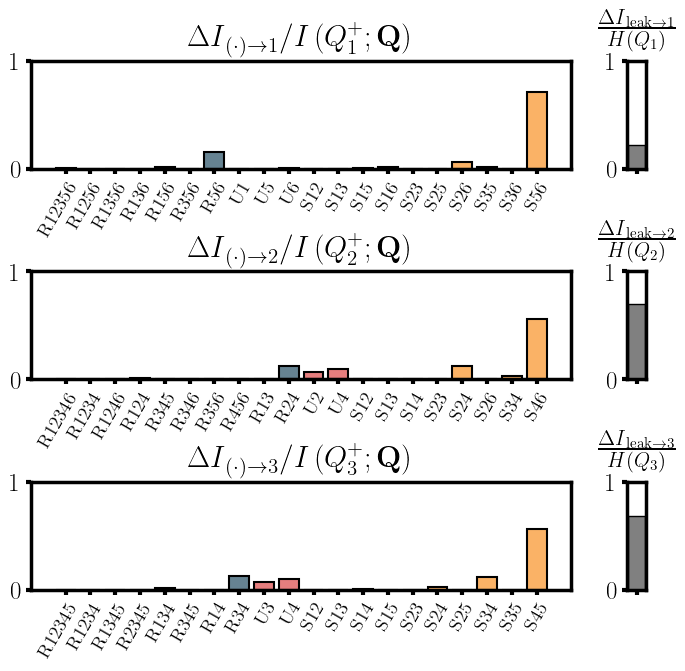

In [55]:
fig, axs = plt.subplots(nvars, 2, figsize=(9, 2.3*nvars), gridspec_kw={'width_ratios': [50, 1]})

for i in range(nvars):
    _ = surd.plot_nlabels(modify_keys(Rd_results[i+1],i+1), modify_keys(Sy_results[i+1],i+1), info_leak_results[i+1], axs[i,:], nvars*nlag+nvars, nlabels=20)
    # Plot formatting
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$', pad=10)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1} \\right)}}$', pad=18)
    axs[i,1].set_yticks([0,1])
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=14, rotation = 60, ha = 'right', rotation_mode='anchor')

    # change all spines
    for axis in ['top','bottom','left','right']:
        axs[i,0].spines[axis].set_linewidth(2.5)
        axs[i,1].spines[axis].set_linewidth(2.5)
    axs[i,0].set_box_aspect(1/5)

plt.tight_layout(w_pad=-7, h_pad=1)